# Comparing Different Statistical Modelling in Financial Markets

### Downloaded the monthly returns of Apple, AT&T, Goldman Sachs from Yahoo in the period 2011/1–2020/12. And assuming the risk aversion 1/λ = 4

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
AAPL = pd.read_csv("AAPL.csv")
GS = pd.read_csv("GS.csv")
ATNT = pd.read_csv("ATNT.csv")
LIBOR = pd.read_csv("LIBOR.csv")

In [ ]:
AAPL["Return"] = AAPL["Close"] - AAPL["Open"]
GS["Return"] = GS["Close"] - GS["Open"]
ATNT["Return"] = ATNT["Close"] - ATNT["Open"]
LIBOR["Rate"] = LIBOR["Rate"]/100

lam = 0.25
N = 3
ones = np.array([[1], [1], [1]])
ones_t = np.transpose(ones)

In [ ]:
def expected_return(weight, asset):
    exp_return = []
    for i in range(len(asset)):
        a = 0
        for j in range(len(weight)):
            a += weight[j] * asset.iloc[i,j]
        exp_return.append(a)
    return pd.Series(exp_return)


###  Part A. Used the asset returns in the period 2011/1–2015/12 to find the MLE, unbiased estimate, James-Stein estimate, and Jorion estimate of the optimal portfolio. Use the asset returns in the period 2016/1–2020/12 to do out-of-sample test: compare the expected return, standard deviation of the return, Sharpe ratio of the estimated optimal portfolio, and the objective value of the mean-variance problem.

In [ ]:
AAPL_1 = AAPL["Return"].iloc[np.where(AAPL["Date"] == "1/1/2011")[0][0]:np.where(AAPL["Date"] == "12/1/2015")[0][0]+1]
AAPL_2 = AAPL["Return"].iloc[np.where(AAPL["Date"] == "1/1/2016")[0][0]:]
GS_1 = GS["Return"].iloc[np.where(GS["Date"] == "1/1/2011")[0][0]:np.where(GS["Date"] == "12/1/2015")[0][0]+1]
GS_2 = GS["Return"].iloc[np.where(GS["Date"] == "1/1/2016")[0][0]:]
ATNT_1 = ATNT["Return"].iloc[np.where(ATNT["Date"] == "1/1/2011")[0][0]:np.where(ATNT["Date"] == "12/1/2015")[0][0]+1]
ATNT_2 = ATNT["Return"].iloc[np.where(ATNT["Date"] == "1/1/2016")[0][0]:]
rf_rate = LIBOR["Rate"].iloc[np.where(LIBOR["Date"] == "1/1/2016")[0][0]:]

T = len(AAPL_1)
cov = np.cov(np.array([AAPL_1, GS_1, ATNT_1]), bias = True)

### MLE

In [ ]:
# Finding optimal weight
miu_mle = np.array([[AAPL_1.mean()], [GS_1.mean()], [ATNT_1.mean()]])
cov_mle = np.cov(np.array([AAPL_1, GS_1, ATNT_1]), bias = True)
cov_mle_inv = np.linalg.inv(cov_mle)
w_mle = lam * np.dot(cov_mle_inv, miu_mle)

# Calculating
exp_return_mle_a = expected_return(w_mle, pd.concat([AAPL_2,GS_2,ATNT_2], axis = 1))
std_mle_a = np.std(exp_return_mle_a)
excess_return_mle_a = np.array(exp_return_mle_a) - rf_rate
sharpe_mle_a = np.mean(excess_return_mle_a) / np.std(excess_return_mle_a)
meanvar_mle_a = lam * np.mean(exp_return_mle_a) - 0.5 * np.var(exp_return_mle_a)

### Unbiased

In [ ]:
w_unbiased = (T - N - 2) * w_mle / T

# Calculating
exp_return_unbiased_a = expected_return(w_unbiased, pd.concat([AAPL_2,GS_2,ATNT_2], axis = 1))
std_unbiased_a = np.std(exp_return_unbiased_a)
excess_return_unbiased_a = np.array(exp_return_unbiased_a) - rf_rate
sharpe_unbiased_a = np.mean(excess_return_unbiased_a) / np.std(excess_return_unbiased_a)
meanvar_unbiased_a = lam * np.mean(exp_return_unbiased_a) - 0.5 * np.var(exp_return_unbiased_a)

### James-stein

In [ ]:
grandmean = np.dot(ones_t, miu_mle) / N
cov_js_inv = (T - N - 2) * cov_mle_inv / T
denominator = miu_mle - (grandmean * ones)
alpha_js = ((N - 2) / T) / (np.transpose(denominator) @ cov_js_inv @ denominator)
if alpha_js > 1:
    alpha_js = 1
miu_js = ((1 - alpha_js) * miu_mle) + (alpha_js * grandmean * ones)
w_js = lam * np.dot(cov_js_inv, miu_js)

# Calculating
exp_return_js_a = expected_return(w_js, pd.concat([AAPL_2,GS_2,ATNT_2], axis = 1))
std_js_a = np.std(exp_return_js_a)
excess_return_js_a = np.array(exp_return_js_a) - rf_rate
sharpe_js_a = np.mean(excess_return_js_a) / np.std(excess_return_js_a)
meanvar_js_a = lam * np.mean(exp_return_js_a) - 0.5 * np.var(exp_return_js_a)

### Jorion

In [ ]:
cov_j_inv = cov_js_inv
denominator = np.dot(cov_j_inv, ones)
r_min = np.dot(np.transpose(miu_mle), denominator) / np.dot(ones_t, denominator)
denominator = miu_mle - (r_min * ones)
alpha_j = (N + 2) / (N + 2 + (np.transpose(denominator) @ (T * cov_j_inv) @ denominator))
miu_j = ((1 - alpha_j) * miu_mle) + (alpha_j * r_min * ones)
w_j = lam * np.dot(cov_j_inv, miu_j)

# Calculating
exp_return_j_a = expected_return(w_j, pd.concat([AAPL_2,GS_2,ATNT_2], axis = 1))
std_j_a = np.std(exp_return_j_a)
excess_return_j_a = np.array(exp_return_j_a) - rf_rate
sharpe_j_a = np.mean(excess_return_j_a) / np.std(excess_return_j_a)
meanvar_j_a = lam * np.mean(exp_return_j_a) - 0.5 * np.var(exp_return_j_a)

### Comparison

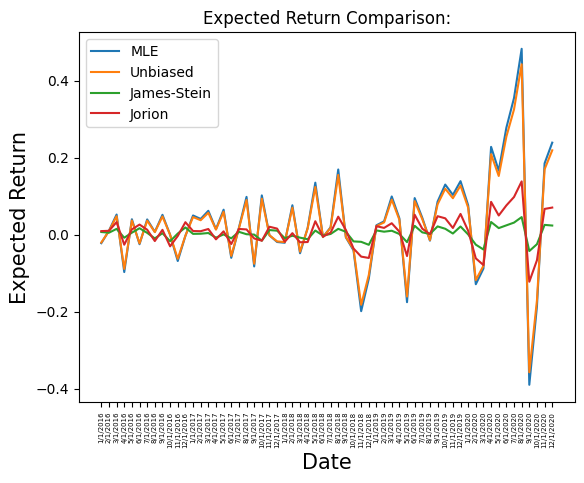

Standard Deviation Comparison:
MLE: 0.13165032831959123
Unbiased: 0.12067946762629198
James_stein: 0.016817173765604654
Jorion: 0.043696486036549576
Sharpe Ratio Comparison:
MLE: [0.16168004]
Unbiased: [0.15278226]
James_stein: [-0.52402241]
Jorion: [-0.09512244]
Mean-Variance Objective Value Comparison:
MLE: [-8.75136591e-05]
Unbiased: [0.00058176]
James_stein: [0.00046323]
Jorion: [0.00114555]


In [ ]:
plt.plot(AAPL["Date"].iloc[np.where(AAPL["Date"] == "1/1/2016")[0][0]:], exp_return_mle_a, label = "MLE")
plt.plot(exp_return_unbiased_a, label = "Unbiased")
plt.plot(exp_return_js_a, label = "James-Stein")
plt.plot(exp_return_j_a, label = "Jorion")
plt.title("Expected Return Comparison:")
plt.xlabel('Date', fontsize=15)
plt.ylabel('Expected Return', fontsize=15)
plt.xticks(rotation=90, fontsize=5)
plt.legend()
plt.show()

print("Standard Deviation Comparison:")
print("MLE:", std_mle_a)
print("Unbiased:", std_unbiased_a)
print("James_stein:", std_js_a)
print("Jorion:", std_j_a)

print("Sharpe Ratio Comparison:")
print("MLE:", sharpe_mle_a)
print("Unbiased:", sharpe_unbiased_a)
print("James_stein:", sharpe_js_a)
print("Jorion:", sharpe_j_a)

print("Mean-Variance Objective Value Comparison:")
print("MLE:", meanvar_mle_a)
print("Unbiased:", meanvar_unbiased_a)
print("James_stein:", meanvar_js_a)
print("Jorion:", meanvar_j_a)

### Part B. Starting from the end of 2015, at the end of every month, used the historical asset returns (from 2011/1 to the end of that month) to find the MLE, unbiased estimate, James-Stein estimate, and Jorion estimate of the optimal portfolio and applied the resulting portfolio in the following month. Calculated the realized monthly returns using these four portfolios from 2016/1 to 2020/12 and perform out-of-sample test.


In [ ]:
period = len(AAPL_2)
period

exp_return_mle_b = []
exp_return_unbiased_b = []
exp_return_js_b = []
exp_return_j_b = []

for i in range(period):
    AAPL_1a = AAPL["Return"].iloc[np.where(AAPL["Date"] == "1/1/2011")[0][0]:np.where(AAPL["Date"] == "12/1/2015")[0][0]+1+i]
    AAPL_2b = AAPL["Return"].iloc[np.where(AAPL["Date"] == "1/1/2016")[0][0]+i]
    GS_1 = GS["Return"].iloc[np.where(GS["Date"] == "1/1/2011")[0][0]:np.where(GS["Date"] == "12/1/2015")[0][0]+1+i]
    GS_2 = GS["Return"].iloc[np.where(GS["Date"] == "1/1/2016")[0][0]+i]
    ATNT_1 = ATNT["Return"].iloc[np.where(ATNT["Date"] == "1/1/2011")[0][0]:np.where(ATNT["Date"] == "12/1/2015")[0][0]+1+i]
    ATNT_2 = ATNT["Return"].iloc[np.where(ATNT["Date"] == "1/1/2016")[0][0]+i]
    rf_rate = LIBOR["Rate"].iloc[np.where(LIBOR["Date"] == "1/1/2016")[0][0]+i]

    # MLE
    miu_mle = np.array([[AAPL_1a.mean()], [GS_1.mean()], [ATNT_1.mean()]])
    cov_mle = np.cov(np.array([AAPL_1a, GS_1, ATNT_1]), bias = True)
    cov_mle_inv = np.linalg.inv(cov_mle)
    w_mle = lam * np.dot(cov_mle_inv, miu_mle)

    exp_return_mle_i = w_mle[0] * AAPL_2b + w_mle[1] * GS_2 + w_mle[2] * ATNT_2
    exp_return_mle_b.append(exp_return_mle_i)

    # Unbiased
    w_unbiased = (T - N - 2) * w_mle / T

    exp_return_unbiased_i = w_unbiased[0] * AAPL_2b + w_unbiased[1] * GS_2 + w_unbiased[2] * ATNT_2
    exp_return_unbiased_b.append(exp_return_unbiased_i)

    # James-Stein
    grandmean = np.dot(ones_t, miu_mle) / N
    cov_js_inv = (T - N - 2) * cov_mle_inv / T
    denominator = miu_mle - (grandmean * ones)
    alpha_js = ((N - 2) / T) / (np.transpose(denominator) @ cov_js_inv @ denominator)
    if alpha_js > 1:
        alpha_js = 1
    miu_js = ((1 - alpha_js) * miu_mle) + (alpha_js * grandmean * ones)
    w_js = lam * np.dot(cov_js_inv, miu_js)

    exp_return_js_i = w_js[0] * AAPL_2b + w_js[1] * GS_2 + w_js[2] * ATNT_2
    exp_return_js_b.append(exp_return_js_i)

    # Jorion
    cov_j_inv = cov_js_inv
    denominator = np.dot(cov_j_inv, ones)
    r_min = np.dot(np.transpose(miu_mle), denominator) / np.dot(ones_t, denominator)
    denominator = miu_mle - (r_min * ones)
    alpha_j = (N + 2) / (N + 2 + (np.transpose(denominator) @ (T * cov_j_inv) @ denominator))
    miu_j = ((1 - alpha_j) * miu_mle) + (alpha_j * r_min * ones)
    w_j = lam * np.dot(cov_j_inv, miu_j)

    exp_return_j_i = w_j[0] * AAPL_2b + w_j[1] * GS_2 + w_j[2] * ATNT_2
    exp_return_j_b.append(exp_return_j_i)

In [ ]:
std_mle_b = np.std(exp_return_mle_b)
excess_return_mle_b = np.array(exp_return_mle_b) - rf_rate
sharpe_mle_b = np.mean(excess_return_mle_b) / np.std(excess_return_mle_b)
meanvar_mle_b = lam * np.mean(exp_return_mle_b) - 0.5 * np.var(exp_return_mle_b)

std_unbiased_b = np.std(exp_return_unbiased_b)
excess_return_unbiased_b = np.array(exp_return_unbiased_b) - rf_rate
sharpe_unbiased_b = np.mean(excess_return_unbiased_b) / np.std(excess_return_unbiased_b)
meanvar_unbiased_b = lam * np.mean(exp_return_unbiased_b) - 0.5 * np.var(exp_return_unbiased_b)

std_js_b = np.std(exp_return_js_b)
excess_return_js_b = np.array(exp_return_js_b) - rf_rate
sharpe_js_b = np.mean(excess_return_js_b) / np.std(excess_return_js_b)
meanvar_js_b = lam * np.mean(exp_return_js_b) - 0.5 * np.var(exp_return_js_b)

std_j_b = np.std(exp_return_j_b)
excess_return_j_b = np.array(exp_return_j_b) - rf_rate
sharpe_j_b = np.mean(excess_return_j_b) / np.std(excess_return_j_b)
meanvar_j_b = lam * np.mean(exp_return_j_b) - 0.5 * np.var(exp_return_j_b)

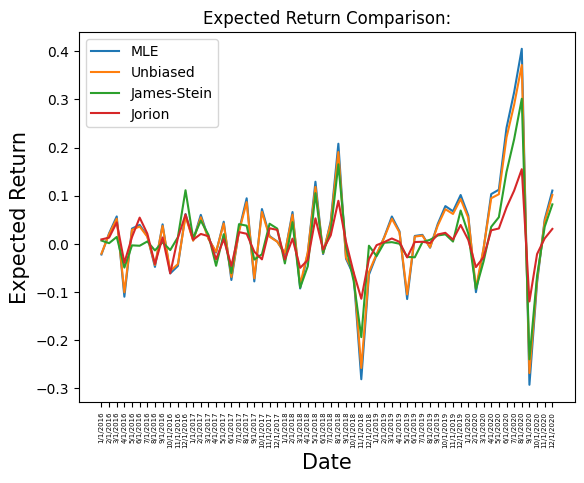

Standard Deviation Comparison:
MLE: 0.1091948121351065
Unbiased: 0.10009524445718096
James-stein: 0.07940534849282965
Jorion: 0.045449922541343384
Sharpe Ratio Comparison:
MLE: 0.1664034857043184
Unbiased: 0.16516391632544472
James-stein: 0.09098612736979664
Jorion: 0.0722301717718273
Mean-Variance Objective Value Comparison:
MLE: -0.0010469291585831191
Unbiased: -0.0005042733364462159
James-stein: -0.0009741833966809398
Jorion: 0.00016009119853731268


In [ ]:
plt.plot(AAPL["Date"].iloc[np.where(AAPL["Date"] == "1/1/2016")[0][0]:], exp_return_mle_b, label = "MLE")
plt.plot(exp_return_unbiased_b, label = "Unbiased")
plt.plot(exp_return_js_b, label = "James-Stein")
plt.plot(exp_return_j_b, label = "Jorion")
plt.title("Expected Return Comparison:")
plt.xlabel('Date', fontsize=15)
plt.ylabel('Expected Return', fontsize=15)
plt.xticks(rotation=90, fontsize=5)
plt.legend()
plt.show()

print("Standard Deviation Comparison:")
print("MLE:", std_mle_b)
print("Unbiased:", std_unbiased_b)
print("James-stein:", std_js_b)
print("Jorion:", std_j_b)

print("Sharpe Ratio Comparison:")
print("MLE:", sharpe_mle_b)
print("Unbiased:", sharpe_unbiased_b)
print("James-stein:", sharpe_js_b)
print("Jorion:", sharpe_j_b)

print("Mean-Variance Objective Value Comparison:")
print("MLE:", meanvar_mle_b)
print("Unbiased:", meanvar_unbiased_b)
print("James-stein:", meanvar_js_b)
print("Jorion:", meanvar_j_b)

##  Compared the out-of-sample Sharpe ratios of the unbiased estimate, James-Stein estimate, Jorion estimate

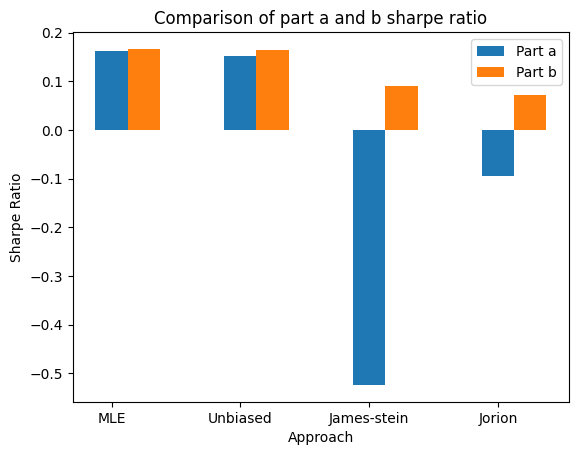

In [ ]:
approach = ["MLE","Unbiased","James-stein","Jorion"]
x_axis = np.arange(len(approach))
width = 0.25

sharpe_a = [sharpe_mle_a[0], sharpe_unbiased_a[0], sharpe_js_a[0], sharpe_j_a[0]]
sharpe_b = [sharpe_mle_b, sharpe_unbiased_b, sharpe_js_b, sharpe_j_b]

plt.bar(x_axis, sharpe_a, 
    width = width, label = "Part a")
plt.bar(x_axis + width, sharpe_b, 
    width = width, label = "Part b")

plt.xticks(x_axis, approach)
plt.xlabel("Approach")
plt.ylabel("Sharpe Ratio")
plt.title("Comparison of part a and b sharpe ratio")
plt.legend()
plt.show()

### Part C.  Consider a market with one risk-free asset and three global assets: US stocks, Euro Stocks, and Japanese Stocks. The market capitalizations of these three assets are 35, 10, and 5 billion, respectively. The covariance matrix of the returns of these three assets are estimated as follows 
#### US Euro Japan 
#### US 7.344% 2.015% 3.309%
#### Euro 2.015% 4.410% 1.202%
#### Japan 3.309% 1.202% 3.497%
### The market risk premium is estimated to be 6%. Apply the Black-Litterman model to compute the optimal allocation to US, Euro, and Japanese stocks. Assume his risk aversion degree 1/λ = 4. Assume τ = 0.1, 1, and 10, and
#### P =
#### 1 0 0
#### −1 1 0
#### , q =
#### 2.5%
#### 2%
#### , Ω =
#### (2%) 2 0
#### 0 (1.5%) 2

## Black Litterman

In [ ]:
def sum_of_cov(mat):
    r = len(mat)
    c = len(mat[0])
    sum = 0
    sum+=np.diag(mat).sum()
    for i in range(r):
        for j in range(c):
            if (i<j):
                sum += 2 * mat[i][j]
    return sum

In [ ]:
p = [[1,0,0],[-1,1,0]]
q = [0.025,0.02]
omega = [[0.0004,0],[0,0.000225]]
cov = [[0.07344,0.02015,0.03309],
    [0.02015,0.04410,0.01202],
    [0.03309,0.01202,0.03497]]
cov_inv = np.linalg.inv(cov)
lam = 1/4

w_market = [35, 10, 5]
var_market = sum_of_cov(cov)
rp_market = 0.06
tao_market = [0.1,1,10]

In [ ]:
pi = rp_market / var_market * np.dot(cov,w_market)
sigma1 = tao_market[0] * np.array(cov)
sigma2 = tao_market[1] * np.array(cov)
sigma3 = tao_market[2] * np.array(cov)

In [ ]:
miu_bl = []
for tao in tao_market:
    miu_i = pi + np.dot(np.dot(np.dot(tao,np.transpose(p)),np.linalg.inv(np.dot(np.dot(p,tao),np.transpose(p)) + omega)),(q - np.dot(p,pi)))
    miu_bl.append(miu_i)

In [ ]:
cov_bl = []
for tao in tao_market:
    cov_i = np.array(cov) + np.array(tao) - np.dot(np.dot(np.dot(np.dot(tao,np.transpose(p)),np.linalg.inv(np.dot(np.dot(p,tao),np.transpose(p)) + omega)),p),tao)
    cov_bl.append(cov_i)
cov_bl

[array([[0.07383683, 0.12054594, 0.13309   ],
        [0.12054594, 0.04471954, 0.11202   ],
        [0.13309   , 0.11202   , 0.13497   ]]),
 array([[0.07383968, 1.02054959, 1.03309   ],
        [1.02054959, 0.04472445, 1.01202   ],
        [1.03309   , 1.01202   , 1.03497   ]]),
 array([[ 0.07383997, 10.02054996, 10.03309   ],
        [10.02054996,  0.04472494, 10.01202   ],
        [10.03309   , 10.01202   , 10.03497   ]])]

In [ ]:
w_bl = []
for i in range(len(tao_market)):
    w_i = lam * np.dot(np.linalg.inv(cov_bl[i]),miu_bl[i])
    w_bl.append(w_i)
    print("For market with tao =", tao_market[i], ", the optimal weight for asset US, Euro, Japan respectively is:", w_i)

For market with tao = 0.1 , the optimal weight for asset US, Euro, Japan respectively is: [ 1.44164657  1.37388129 -1.99121548]
For market with tao = 1 , the optimal weight for asset US, Euro, Japan respectively is: [ 0.07442889  0.06851619 -0.06687627]
For market with tao = 10 , the optimal weight for asset US, Euro, Japan respectively is: [ 0.00711159  0.00660223 -0.00602257]
